In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn import preprocessing
import keras
import numpy as np

Using TensorFlow backend.


In [2]:
url = "https://tfhub.dev/google/elmo/2"
embed = hub.Module(url)

#include the dataset

data = pd.read_csv('spam.csv', encoding='latin-1')

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/elmo/2'.
INFO:tensorflow:Downloading https://tfhub.dev/google/elmo/2: 180.35MB
INFO:tensorflow:Downloading https://tfhub.dev/google/elmo/2: 357.40MB
INFO:tensorflow:Downloaded https://tfhub.dev/google/elmo/2, Total size: 357.40MB
INFO:tensorflow:Downloaded TF-Hub Module 'https://tfhub.dev/google/elmo/2'.
INFO:tensorflow:Initialize variable module/aggregation/scaling:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/scaling
INFO:tensorflow:Initialize variable module/aggregation/weights:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with aggregation/weights
INFO:tensorflow:Initialize variable module/bilm/CNN/W_cnn_0:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/CNN/W_cnn_0
INFO:t

INFO:tensorflow:Initialize variable module/bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/RNN_1/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel
INFO:tensorflow:Initialize variable module/bilm/char_embed:0 from checkpoint b'/tmp/tfhub_modules/9bb74bc86f9caffc8c47dd7b33ec4bb354d9602d/variables/variables' with bilm/char_embed


In [5]:
#verifying the dimensions of the data
data.shape

(5572, 5)

In [6]:
y = list(data['v1'])
x = list(data['v2'])

In [7]:
#fitting the model

le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

# Defining encode and decode functions


In [8]:

def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

In [9]:
test = encode(le, ['ham', 'spam', 'ham', 'ham'])

untest = decode(le, test)

# Specifying training and testing data

In [16]:

x_enc = x
y_enc = encode(le, y)

x_train = np.asarray(x_enc[:5572])
y_train = np.asarray(y_enc[:5572])

x_test = np.asarray(x_enc[2000:])
y_test = np.asarray(y_enc[2000:])

In [11]:
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K
from keras.callbacks import ModelCheckpoint

In [12]:
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

# Specifying the metrics for training

In [13]:


input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(2, activation='softmax')(dense) 
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint = ModelCheckpoint('weights1.h5', save_best_only=True,
                             monitor='val_loss', verbose=0)

# Training the model

In [39]:


with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(x_train, y_train, epochs=30, validation_split= 0.2, batch_size=60)
    model.save_weights('./elmo-model.h5')

Train on 4457 samples, validate on 1115 samples
Epoch 1/30
4457/4457 [==============================] - 27s 6ms/step - loss: 0.0970 - acc: 0.9693 - val_loss: 0.0533 - val_acc: 0.9785
Epoch 2/30
4457/4457 [==============================] - 27s 6ms/step - loss: 0.0438 - acc: 0.9854 - val_loss: 0.0463 - val_acc: 0.9830
Epoch 3/30
4457/4457 [==============================] - 27s 6ms/step - loss: 0.0551 - acc: 0.9845 - val_loss: 0.0730 - val_acc: 0.9749
Epoch 4/30
4457/4457 [==============================] - 28s 6ms/step - loss: 0.0341 - acc: 0.9892 - val_loss: 0.0461 - val_acc: 0.9812
Epoch 5/30
4457/4457 [==============================] - 28s 6ms/step - loss: 0.0240 - acc: 0.9906 - val_loss: 0.0534 - val_acc: 0.9857
Epoch 6/30
4457/4457 [==============================] - 27s 6ms/step - loss: 0.0514 - acc: 0.9870 - val_loss: 0.0505 - val_acc: 0.9839
Epoch 7/30
4457/4457 [==============================] - 27s 6ms/step - loss: 0.0218 - acc: 0.9930 - val_loss: 0.0434 - val_acc: 0.9874
Epoch 8

# Testing the model

In [40]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model.h5')  
    predicts = model.predict(x_test, batch_size=32)

In [42]:
# y_test = decode(le, y_test)
y_preds = decode(le, predicts)
y_preds

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [52]:
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline


In [55]:
#Confusion matrix for trained and tested data

print(metrics.confusion_matrix(y_test, y_preds))

[[3098    7]
 [   7  460]]


In [45]:
print(metrics.classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      3105
        spam       0.99      0.99      0.99       467

   micro avg       1.00      1.00      1.00      3572
   macro avg       0.99      0.99      0.99      3572
weighted avg       1.00      1.00      1.00      3572



# Plotting the results

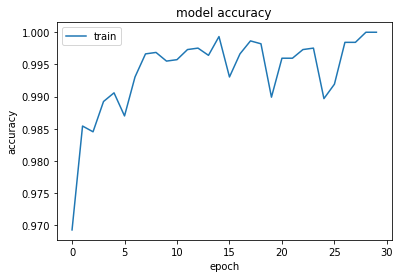

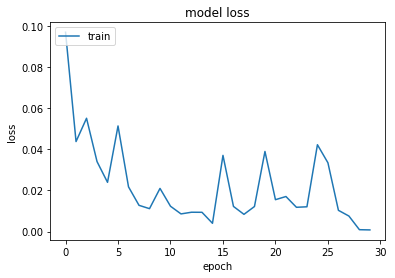

In [49]:
hist = pd.DataFrame(history.history)

# summarize history for accuracy
plt.plot(hist['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()